In [313]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras import layers
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from datetime import datetime
import csv

In [314]:
read_file = pd.read_excel('/content/vendas.xlsx')

In [315]:
read_file

,DATA,VALOR
0,02/01/2017,"33,26"
1,02/01/2017,"21,47"
2,02/01/2017,"12,21"
3,02/01/2017,"30,10"
4,02/01/2017,"15,97"
...,...,...
153776,30/07/2022,"27,28"
153777,30/07/2022,"24,00"
153778,30/07/2022,"65,54"
153779,30/07/2022,"21,64"


In [316]:
read_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153781 entries, 0 to 153780
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   DATA    153781 non-null  object
 1   VALOR   153781 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [317]:
read_file['VALOR'] = read_file['VALOR'].apply(lambda item: float(item.replace(',', '.')))

In [318]:
read_file.head()

,DATA,VALOR
0,02/01/2017,33.26
1,02/01/2017,21.47
2,02/01/2017,12.21
3,02/01/2017,30.10
4,02/01/2017,15.97


In [319]:
read_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153781 entries, 0 to 153780
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DATA    153781 non-null  object 
 1   VALOR   153781 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.3+ MB


In [320]:
read_file['DATA'] = pd.to_datetime(read_file['DATA'], format='%M/%d/%Y').dt.date

In [321]:
read_file

,DATA,VALOR
0,2017-01-01,33.26
1,2017-01-01,21.47
2,2017-01-01,12.21
3,2017-01-01,30.10
4,2017-01-01,15.97
...,...,...
153776,2022-01-07,27.28
153777,2022-01-07,24.00
153778,2022-01-07,65.54
153779,2022-01-07,21.64


In [322]:
df = read_file.groupby('DATA')['VALOR'].sum().cumsum()

In [323]:
df

DATA
2017-01-01      38640.28
2017-01-02      76260.91
2017-01-03     145318.73
2017-01-04     213202.47
2017-01-05     259426.56
                 ...    
2022-01-03    3698822.70
2022-01-04    3748845.38
2022-01-05    3813313.70
2022-01-06    3884847.40
2022-01-07    3954962.72
Name: VALOR, Length: 67, dtype: float64

In [324]:
df.to_csv("resumo_venda.csv", index=True, header=True)

In [325]:
resumo_venda = pd.read_csv('/content/resumo_venda.csv')

In [326]:
resumo_venda

,DATA,VALOR
0,2017-01-01,38640.28
1,2017-01-02,76260.91
2,2017-01-03,145318.73
3,2017-01-04,213202.47
4,2017-01-05,259426.56
...,...,...
62,2022-01-03,3698822.70
63,2022-01-04,3748845.38
64,2022-01-05,3813313.70
65,2022-01-06,3884847.40


In [327]:
resumo_venda.isnull().sum()

DATA     0
VALOR    0
dtype: int64

In [328]:
resumo_venda = resumo_venda.rename(columns = {"DATA": "ds", "VALOR": "y"})

In [329]:
resumo_venda.head()

,ds,y
0,2017-01-01,38640.28
1,2017-01-02,76260.91
2,2017-01-03,145318.73
3,2017-01-04,213202.47
4,2017-01-05,259426.56


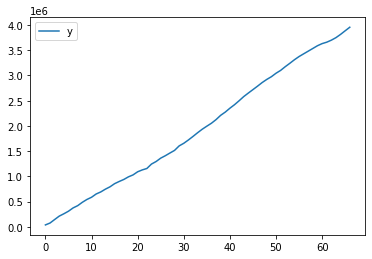

In [330]:
# observando os dados
resumo_venda.plot()

In [331]:
# Criando uma variavel para plotar a dispersão dos dados
eixox = resumo_venda['ds']
eixoy = resumo_venda['y']

In [332]:
fig= px.scatter(eixox,eixoy)
fig.show()

# Prophet: Forecasting at Scale

In [333]:
# Criando modelo para treino
m = Prophet(seasonality_mode="additive",
    weekly_seasonality=False, 
    daily_seasonality=False,
    yearly_seasonality=True)
m.fit(resumo_venda)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpev_wkfmh/921zk0vw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpev_wkfmh/yvg9meo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79148', 'data', 'file=/tmp/tmpev_wkfmh/921zk0vw.json', 'init=/tmp/tmpev_wkfmh/yvg9meo0.json', 'output', 'file=/tmp/tmpev_wkfmh/prophet_modeldmquzeun/prophet_model-20221129121703.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [334]:
# treinando o modelo para previsão de 6 meses a frente
future = m.make_future_dataframe(periods=6)
forecast = m.predict(future)

In [335]:
# verificando se o intervalo de tempo está de acordo com o desejado (6 meses)
len(forecast) - len(resumo_venda)

6

## Gráfico das previsões

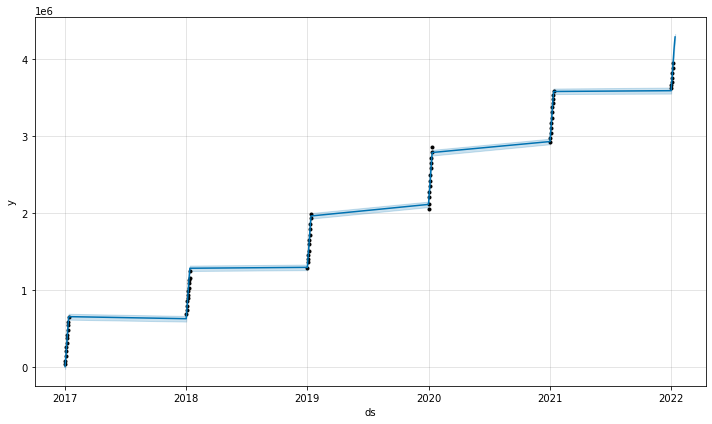

In [336]:
m.plot(forecast);

Tendência de crescimento no faturamento

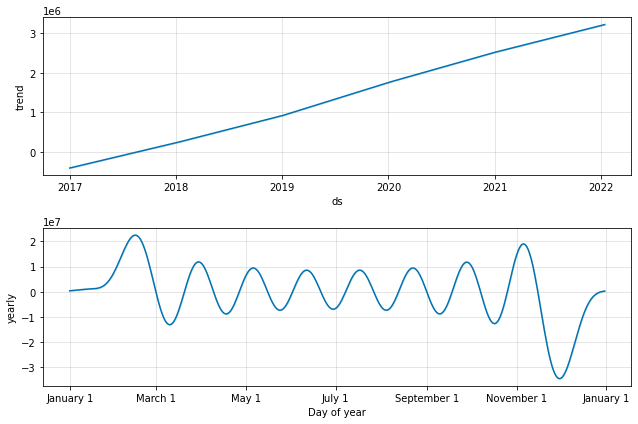

In [337]:
m.plot_components(forecast);

In [338]:
plot_plotly(m, forecast)

In [339]:
plot_components_plotly(m, forecast, figsize=[800,400])

## RNN com Tensorflow

In [340]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [341]:
n_steps = 6
X, y = split_sequence(list(resumo_venda['y']), n_steps)

In [342]:
# define modelo
n_features = 1
model = Sequential()
model.add(layers.SimpleRNN(50, activation='relu', input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse')

In [343]:
X.shape

(61, 6)

In [344]:
# dividindo o dataset 
X = X.reshape((X.shape[0], X.shape[1], n_features))

X_train = X[1:15,:,:]
X_test = X[15:X.shape[0],:,:]

y_train = y[1:15]
y_test  = y[15:X.shape[0]]

In [345]:
# verificando se a divisão dos dados está correta
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(61, 6, 1)
(14, 6, 1)
(46, 6, 1)
(14,)
(46,)


In [346]:
# treinando o modelo
model.fit(X_train, y_train, epochs=5000, verbose=1)

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 7ms/step - loss: 140873616.0000
Epoch 2502/5000
1/1 [==============================] - 0s 7ms/step - loss: 130779672.0000
Epoch 2503/5000
1/1 [==============================] - 0s 7ms/step - loss: 132707696.0000
Epoch 2504/5000
1/1 [==============================] - 0s 6ms/step - loss: 132275336.0000
Epoch 2505/5000
1/1 [==============================] - 0s 7ms/step - loss: 148526896.0000
Epoch 2506/5000
1/1 [==============================] - 0s 6ms/step - loss: 140027376.0000
Epoch 2507/5000
1/1 [==============================] - 0s 6ms/step - loss: 141744912.0000
Epoch 2508/5000
1/1 [==============================] - 0s 7ms/step - loss: 151091248.0000
Epoch 2509/5000
1/1 [==============================] - 0s 7ms/step - loss: 168428560.0000
Epoch 2510/5000
1/1 [==============================] - 0s 7ms/step - loss: 161831280.0000
Epoch 2511/5000
1/1 [==============================] - 0s

In [347]:
# testando o modelo
y_pred=model.predict(X_test)

2/2 [==============================] - 0s 4ms/step


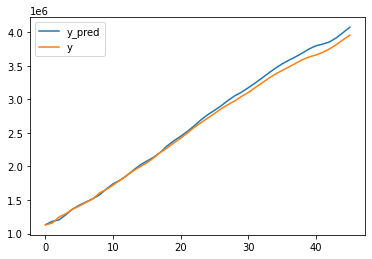

In [348]:
plt.plot(y_pred, label ='y_pred')
plt.plot(y_test, label ='y')
plt.legend()

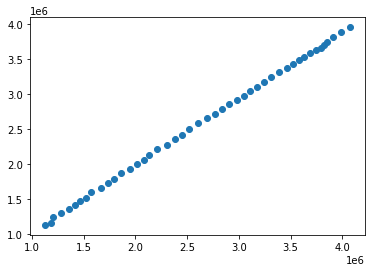

In [349]:
plt.scatter(y_pred, y_test)

In [350]:
resumo_venda.tail()

,ds,y
62,2022-01-03,3698822.70
63,2022-01-04,3748845.38
64,2022-01-05,3813313.70
65,2022-01-06,3884847.40
66,2022-01-07,3954962.72


In [351]:
X_new = resumo_venda["y"][-n_steps:]

In [352]:
X_new

61    3658698.01
62    3698822.70
63    3748845.38
64    3813313.70
65    3884847.40
66    3954962.72
Name: y, dtype: float64

In [353]:
X_new = np.array(X_new).reshape(1, n_steps, 1)

In [354]:
model.predict(X_new)

1/1 [==============================] - 0s 23ms/step


array([[4145163.2]], dtype=float32)

----

# Salvando o Modelo

In [355]:
from joblib import dump , load

In [356]:
dump(m, '/content/m.joblib')

['/content/m.joblib']

----

# Criando API

In [357]:
from flask import Flask, request, url_for, redirect, render_template, jsonify

In [358]:
app = Flask(__name__)

In [359]:
@app.route('/')
def home():
    return render_template('templates/template.html')

In [360]:
@app.route('/predict', methods = ['POST'])
def predict():
    #request of all inputs
    features = [x for x in request.form.values()]
    
    #data preparing
    features_array = np.array(features)
    pandas_features = pd.DataFrame([features_array])
    print(features)
    
    #predict
    pred = model.predict(pandas_features)
    print(pred)
    prediction = int(pred[0])
    return render_template("home.html", pred = "prediction: {}".format(prediction))

In [361]:
@app.route('/model_health/<model_id>', methods = ['GET'])
def model_health(model_id):
    with open('metrics/model_metrics_version_{0}.json'.format(model_id)) as f:
        model_metrics = json.load(f)    
        return model_metrics